# Bayesian Machine Learning Final Project 
### Diyu Zheng, Taylor Rohrich, Congxin (David) Xu



In [1]:
import pandas as pd
import pymc3 as pm
import sklearn.model_selection
import sklearn
from pandas_profiling import ProfileReport
import arviz as az
import seaborn as sns
import numpy as np

## Data Cleaning

#### Read this for full data

In [2]:
# Data Read In and Preview
data = pd.read_csv('LoanStats3d_securev1.csv', skiprows=1, skipfooter=2, engine='python')
#data = pd.read_csv('C:/Users/Apoptoxin/Desktop/DS6014 Baysian Machine Learning/Project/LoanStats3d_securev1.csv', skiprows=1, skipfooter=2, engine='python')
data.head()

KeyboardInterrupt: 

#### This creates small.csv

In [2]:
# Dimensions: 420k + rows and 150 columns
#data.shape
#data = data.sample(frac=.005)
#data.to_csv('small.csv',index=False)

In [3]:
data = pd.read_csv('small.csv')

In [4]:
# Identify the response variable
data.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Current', 'In Grace Period'],
      dtype=object)

In [5]:
# Distribution of the response variable
data.loan_status.value_counts()

Fully Paid         1616
Charged Off         429
Current              59
In Grace Period       1
Name: loan_status, dtype: int64

In [6]:
# For Simplicity, we are only going to assume that all data are either 'Default' or `Fully Paid`
data.loc[data['loan_status'] == 'Charged Off', 'loan_status'] = 'Default'
data.loc[data['loan_status'] != 'Default', 'loan_status'] = 'Fully Paid'
data.loan_status.value_counts()

Fully Paid    1676
Default        429
Name: loan_status, dtype: int64

### Split training and test data
We are going to split the original data into 2 parts, training data and testing data. The Bayesian Logistic Regression model and the Naive Bayes model will only uses the training data to train the model and later, use the test data to generate forecast accuracy metrics and compare the performance with each other.

In [88]:
train, test = sklearn.model_selection.train_test_split(data, test_size=0.2)
train.shape

(1684, 150)

In [89]:
test.shape

(421, 150)

## Bayesian Logistic Regression


For Bayesian Logistic Regression we will consider a full model and  smaller models, removing correlated / statistically insignificant predictors.

In [154]:
train['loan_status'] = train['loan_status'].map({'Fully Paid':0,'Default':1})

<ipython-input-154-50f06b844578>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['loan_status'] = train['loan_status'].map({'Fully Paid':0,'Default':1})


In [155]:
np.abs(train.corr()['loan_status']).sort_values(ascending=False)[:10]

loan_status                                   1.000000
hardship_dpd                                  0.710580
last_fico_range_high                          0.635884
last_fico_range_low                           0.571385
recoveries                                    0.507164
collection_recovery_fee                       0.505262
total_rec_prncp                               0.436170
orig_projected_additional_accrued_interest    0.398206
hardship_payoff_balance_amount                0.372887
open_acc_6m                                   0.357193
Name: loan_status, dtype: float64

In [156]:
# Select potential Predictors
# Changes these to proper names
column_selected = ['loan_status','annual_inc','chargeoff_within_12_mths',
                  'avg_cur_bal','int_rate',
                 'num_actv_bc_tl','num_actv_rev_tl','funded_amnt','grade','fico_range_high','tot_hi_cred_lim','last_fico_range_high','recoveries','total_rec_prncp']
data_selected = train[column_selected]

In [157]:
data_selected['int_rate'] = data_selected['int_rate'].str.replace('%','').astype(float)

<ipython-input-157-0f0155b474bd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['int_rate'] = data_selected['int_rate'].str.replace('%','').astype(float)


In [158]:
data_selected['grade'] = data_selected['grade'].map({'G':0,'F':1,"E":2,"D":3,"C":4,"B":5,'A':6})

<ipython-input-158-15bee7d6364b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected['grade'] = data_selected['grade'].map({'G':0,'F':1,"E":2,"D":3,"C":4,"B":5,'A':6})


In [160]:
# Scale data
def scale_column(col):
    return (col-np.mean(col))/np.std(col)
for column in data_selected.columns:
    if column not in ['loan_status','']:
        data_selected[column] = scale_column(data_selected[column])

<ipython-input-160-08ad751a0185>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_selected[column] = scale_column(data_selected[column])


In [161]:
data_selected.head()

,loan_status,annual_inc,chargeoff_within_12_mths,avg_cur_bal,int_rate,num_actv_bc_tl,num_actv_rev_tl,funded_amnt,grade,fico_range_high,tot_hi_cred_lim,last_fico_range_high,recoveries,total_rec_prncp
1105,0,-0.383028,-0.106824,-0.492566,-0.259150,-1.218840,-0.850578,-1.002301,0.617145,-1.112080,-0.756164,-0.543053,-0.254147,-0.710726
1765,0,2.513267,-0.106824,4.741389,-0.943572,-0.772929,-0.250882,0.609321,0.617145,-0.130301,3.537534,0.222565,-0.254147,0.827717
868,0,0.427351,-0.106824,1.043969,2.961943,0.118892,0.048966,-0.426722,-2.529781,-0.948451,1.329147,-0.071903,-0.254147,-0.272648
1648,0,-0.176467,-0.106824,-0.644867,1.420796,-0.772929,-0.250882,-0.518815,-1.743049,-0.784821,-0.720775,1.223757,-0.254147,-0.249193
177,0,0.454797,-0.106824,0.044106,0.942179,0.564802,1.248357,2.220944,-0.956318,-0.293931,0.484580,0.104778,-0.254147,2.366161


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tot_hi_cred_lim, fico_range_high, grade, num_actv_rev_tl, num_actv_bc_tl, int_rate, avg_cur_bal, total_rec_prncp, last_fico_range_high, intercept]


Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 47 seconds.


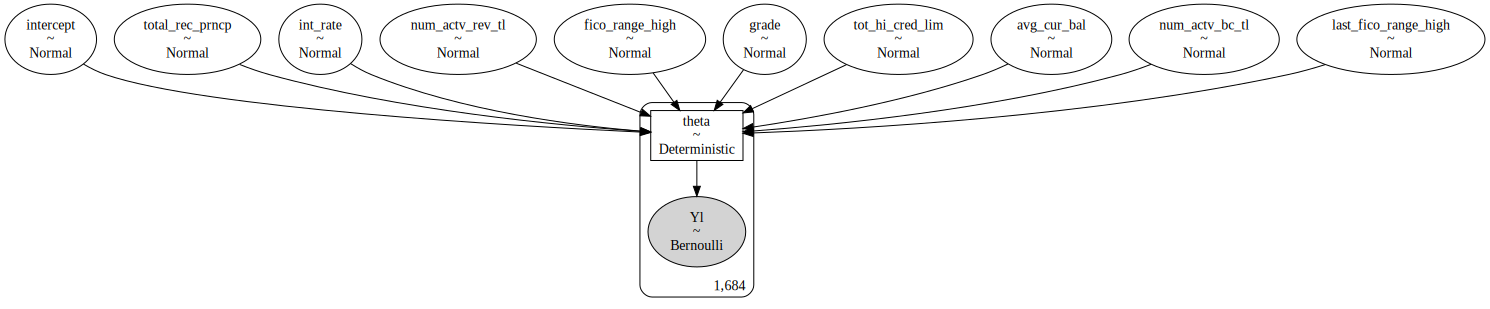

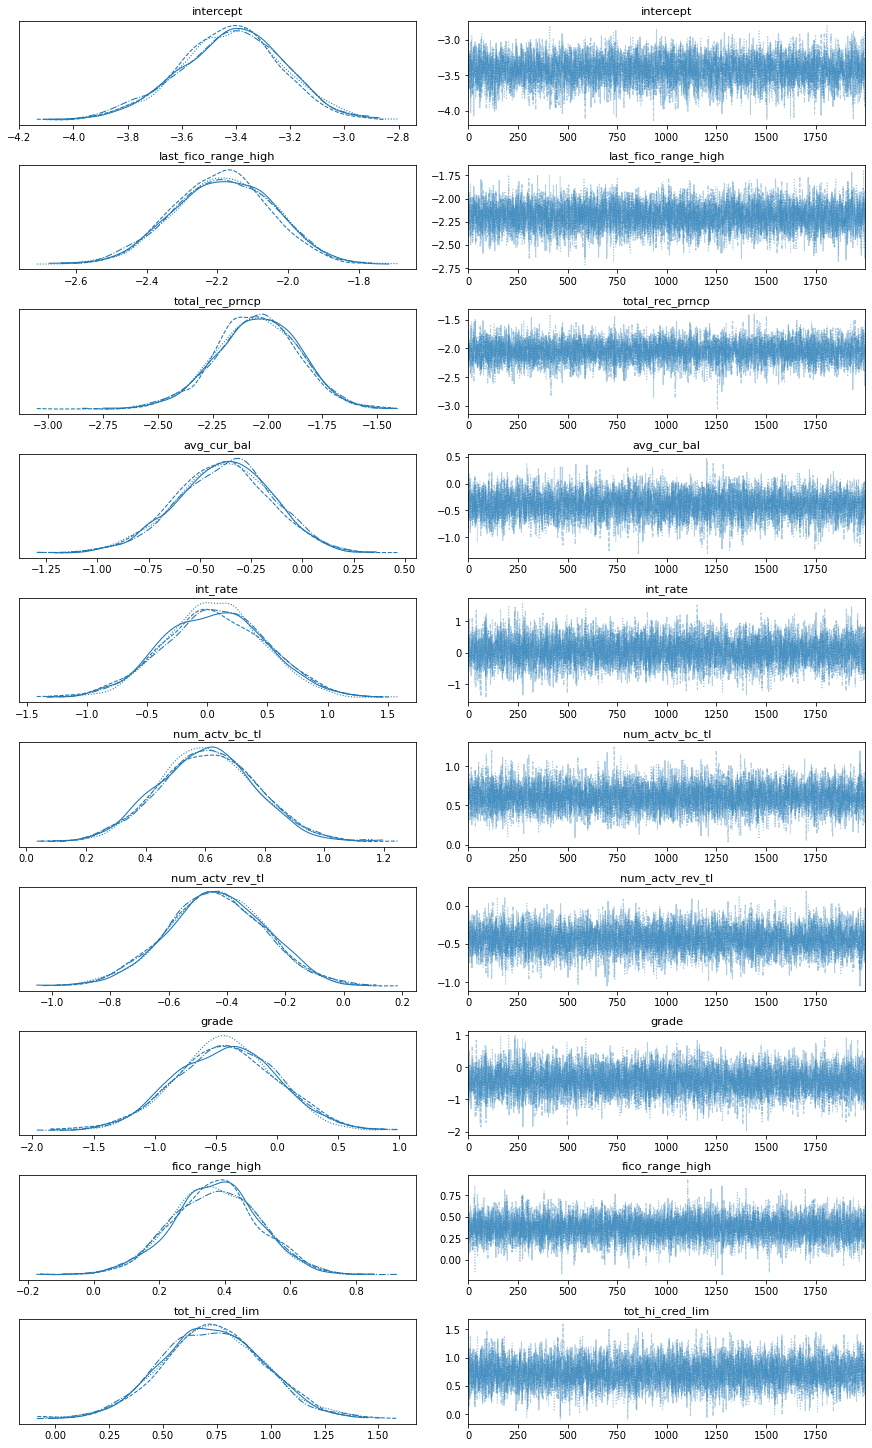

In [162]:
# Full Model Setup
with pm.Model() as full_model_sample:
    y = data_selected['loan_status']
    # Model Betas as uninformed gaussians
    b0 = pm.Normal('intercept', mu=0, sd=1e5) 
    b1 = pm.Normal('last_fico_range_high', mu=0, sd=1e5) 
    b2 = pm.Normal('total_rec_prncp', mu=0, sd=1e5)
    b3 = pm.Normal('avg_cur_bal', mu=0, sd=1e5)
    b4 = pm.Normal('int_rate', mu=0, sd=1e5)
    b5 = pm.Normal('num_actv_bc_tl', mu=0, sd=1e5)
    b6 = pm.Normal('num_actv_rev_tl', mu=0, sd=1e5)
    b7 = pm.Normal('grade', mu=0, sd=1e5)
    b8 = pm.Normal('fico_range_high', mu=0, sd=1e5)
    b9 = pm.Normal('tot_hi_cred_lim', mu=0, sd=1e5)
    # Calculate mu
    mu = b0 + pm.math.dot(data_selected["last_fico_range_high"], b1)+  pm.math.dot(data_selected["total_rec_prncp"], b2)+ \
    pm.math.dot(data_selected["avg_cur_bal"], b3)+  pm.math.dot(data_selected["int_rate"], b4) + \
   pm.math.dot(data_selected["num_actv_bc_tl"], b5) + \
    pm.math.dot(data_selected["num_actv_rev_tl"], b6) +\
     pm.math.dot(data_selected["grade"], b7) +  pm.math.dot(data_selected["fico_range_high"], b8) +\
     pm.math.dot(data_selected["tot_hi_cred_lim"], b9)
    # Use inv logit function
    theta = pm.Deterministic('theta',  pm.invlogit(mu))
    # Calculate bernoulli
    yl = pm.Bernoulli('Yl', p=theta, observed=y)
    trace_full_sample = pm.sample(2000, tune=1500, init='adapt_diag', cores =4)
    pm.traceplot(trace_full_sample,var_names=['intercept','last_fico_range_high','total_rec_prncp',
                  'avg_cur_bal','int_rate',
                 'num_actv_bc_tl','num_actv_rev_tl','grade','fico_range_high','tot_hi_cred_lim'])
pm.model_to_graphviz(full_model_sample)

/opt/miniconda3/envs/python3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


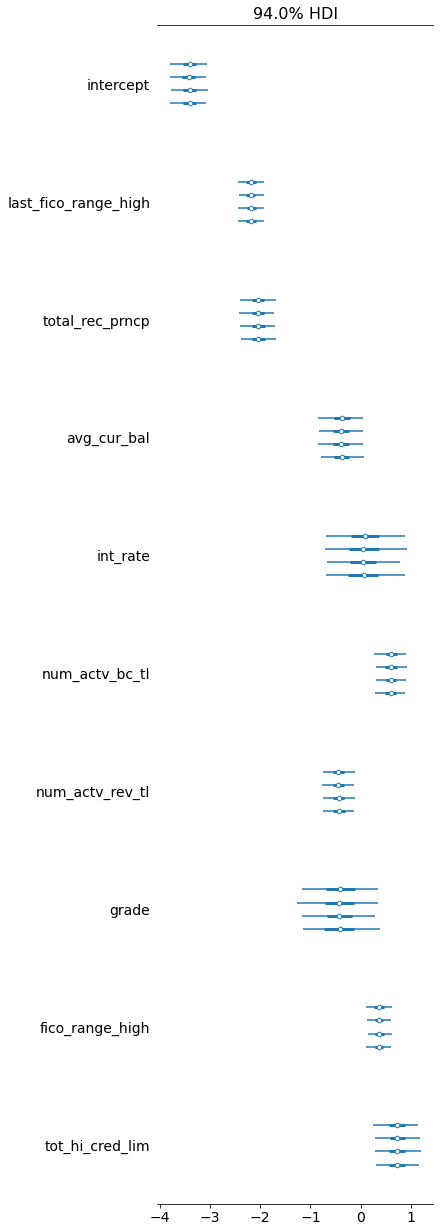

In [163]:
az.plot_forest(trace_full_sample, var_names=['intercept','last_fico_range_high','total_rec_prncp',
                  'avg_cur_bal','int_rate',
                 'num_actv_bc_tl','num_actv_rev_tl','grade','fico_range_high','tot_hi_cred_lim']);

In [164]:
soft_classification = trace_full_sample['theta'].mean(axis=0)
hard_classification = np.array(list(map(lambda x: 1 if x >= .5 else 0,soft_classification)))
n = len(hard_classification)
np.sum(hard_classification == data_selected['loan_status']) /n


0.918646080760095

In [165]:
sklearn.metrics.confusion_matrix(data_selected['loan_status'],hard_classification )

array([[1291,   55],
       [  82,  256]])

## Reduced Logistic Regression Model

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tot_hi_cred_lim, fico_range_high, num_actv_bc_tl, total_rec_prncp, last_fico_range_high, intercept]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


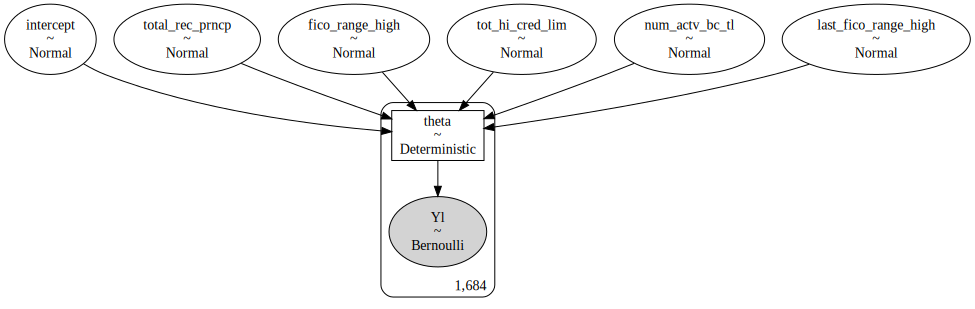

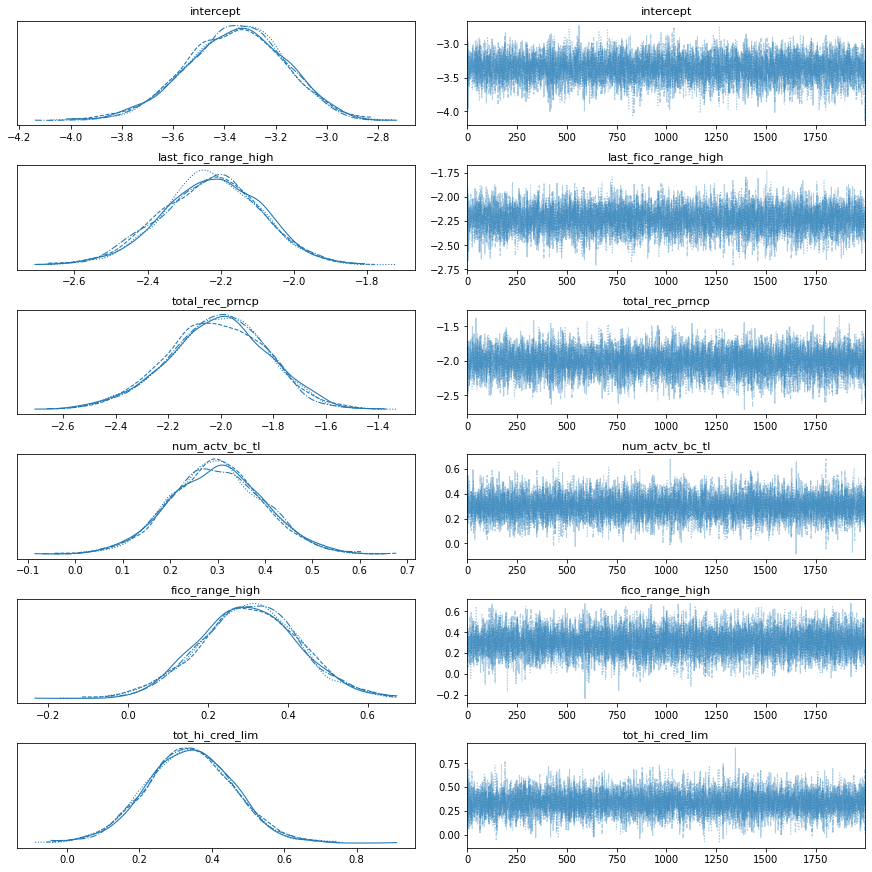

In [166]:
# Reduced Model Setup
with pm.Model() as reduced_model_sample:
    y = data_selected['loan_status']
    # Model Betas as uninformed gaussians
    b0 = pm.Normal('intercept', mu=0, sd=1e5) 
    b1 = pm.Normal('last_fico_range_high', mu=0, sd=1e5) 
    b2 = pm.Normal('total_rec_prncp', mu=0, sd=1e5)  
    b3 = pm.Normal('num_actv_bc_tl', mu=0, sd=1e5)
    b4 = pm.Normal('fico_range_high', mu=0, sd=1e5)
    b5 = pm.Normal('tot_hi_cred_lim', mu=0, sd=1e5)
    # Calculate mu
    mu = b0 + pm.math.dot(data_selected["last_fico_range_high"], b1)+ \
    pm.math.dot(data_selected["total_rec_prncp"], b2)+  pm.math.dot(data_selected["num_actv_bc_tl"], b3) + \
    pm.math.dot(data_selected["fico_range_high"], b4) + pm.math.dot(data_selected["tot_hi_cred_lim"], b5)
    # Use inv logit function
    theta = pm.Deterministic('theta',  pm.invlogit(mu))
    # Calculate bernoulli
    yl = pm.Bernoulli('Yl', p=theta, observed=y)
    trace_reduced_sample = pm.sample(2000, tune=1000, init='adapt_diag', cores =4)
    pm.traceplot(trace_reduced_sample,var_names=['intercept','last_fico_range_high','total_rec_prncp','num_actv_bc_tl','fico_range_high',
                                                'tot_hi_cred_lim'])
pm.model_to_graphviz(reduced_model_sample)

In [167]:
soft_classification = trace_reduced_sample['theta'].mean(axis=0)
hard_classification = np.array(list(map(lambda x: 1 if x >= .5 else 0,soft_classification)))
n = len(hard_classification)
np.sum(hard_classification == data_selected['loan_status']) /n

0.91270783847981

In [168]:
sklearn.metrics.confusion_matrix( data_selected['loan_status'], hard_classification)

array([[1284,   62],
       [  85,  253]])

## Hierarchical Model

## Boltzman Machine

## Bayesian Model Averaging

In [172]:
# Model comparisons with WAIC and weights

cmp_df = az.compare({'model_full':trace_full_sample, 'model_reduced':trace_reduced_sample}, ic = 'WAIC',
                    method='BB-pseudo-BMA')
# Model weights
cmp_df

/opt/miniconda3/envs/python3/lib/python3.8/site-packages/arviz/stats/stats.py:149: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  warnings.warn(
/opt/miniconda3/envs/python3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/opt/miniconda3/envs/python3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnin

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_full,0,-351.68,9.85762,0,0.967805,21.4992,0,False,log
model_reduced,1,-361.554,6.32169,9.87373,0.0321949,21.785,5.12572,False,log


In [173]:
# Computing predictions by combining the models using the WAIC weights

#np.exp(-0.5*waic_p[0])/(np.exp(-0.5*waic_l[0]) + np.exp(-0.5*waic_p[0]))
# or use the value given in the table
w_full= cmp_df.loc['model_full','weight']
w_reduced= cmp_df.loc['model_reduced','weight']

weights = [w_full,w_reduced]

In [174]:
# BMA Model
y_bma = pm.sample_posterior_predictive_w(traces = [trace_full_sample,trace_reduced_sample],
                                        samples=1000,
                                        models=[full_model_sample, reduced_model_sample],
                                        weights=weights)
# Full Model
y_full = pm.sample_posterior_predictive_w(traces = [trace_full_sample],
                                        samples=1000,
                                         models=[full_model_sample])
# Reduced
y_m2 = pm.sample_posterior_predictive_w(traces = [trace_reduced_sample],
                                        samples=1000,
                                        models=[ reduced_model_sample])

<AxesSubplot:>

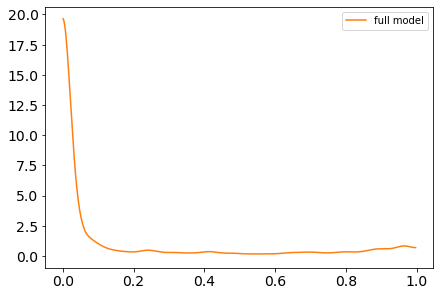

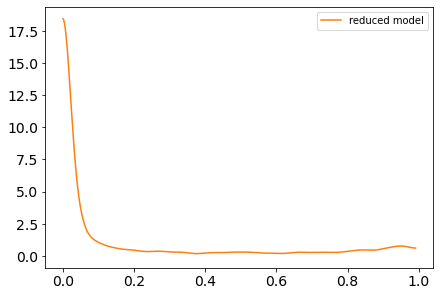

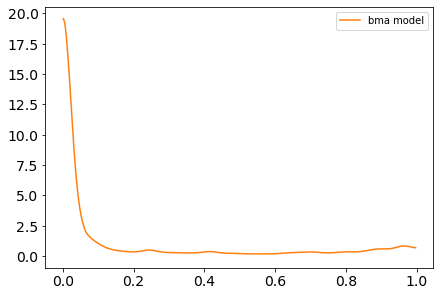

In [175]:
az.plot_kde(trace_full_sample['theta'].mean(axis=0), plot_kwargs={'color': 'C1'}, label='full model',)
az.plot_kde(trace_reduced_sample['theta'].mean(axis=0), plot_kwargs={'color': 'C1'}, label='reduced model',)
theta_bma = trace_full_sample['theta'].mean(axis=0)*weights[0]+ trace_reduced_sample['theta'].mean(axis=0)*weights[1]
az.plot_kde(theta_bma, plot_kwargs={'color': 'C1'}, label='bma model',)

## Naive Bayes Classifier
The Naive Bayes Classifier model is going to focus on the following variables: 
- `term`: Term of the load. "36 months" or "60 months"
- `grade`: Load Grade, A to G
- `sub_grade`: Each letter grade will have 6 subgrace, A1 to A6
- `emp_title`: Title of the employment of the borrower
- `emp_length`: The length of the employment
- `home_ownership`: Whether the borrows own a home.
- `purpose`: The purpose of taking the load
- `addr_state`: The state of the residence for the borrower.


In [ ]:
# Select the categorical variable from the training data 
naive_column = [ 'loan_status', 'term','grade','sub_grade','emp_length','home_ownership','purpose','addr_state']
train_naive = train[naive_column].fillna('NA')
train_naive.head()

,loan_status,term,grade,sub_grade,emp_length,home_ownership,purpose,addr_state
417489,Fully Paid,60 months,F,F2,< 1 year,RENT,debt_consolidation,TX
199300,Default,60 months,G,G4,10+ years,RENT,debt_consolidation,MD
135569,Fully Paid,60 months,B,B1,6 years,MORTGAGE,credit_card,PA
30741,Fully Paid,36 months,C,C2,2 years,MORTGAGE,debt_consolidation,IN
343896,Default,36 months,C,C5,7 years,MORTGAGE,small_business,MD


In [ ]:
# Add Column Names to each of the values within that column
d_train = dict()
d_train['loan_status'] = list(train_naive.iloc[:, 0])

for i in range(1, len(train_naive.keys())):
    d_train[train_naive.keys()[i]] = list(train_naive.keys()[i] + "_" + train_naive.iloc[:, i])

new_train = pd.DataFrame(data = d_train)
new_train.head()

,loan_status,term,grade,sub_grade,emp_length,home_ownership,purpose,addr_state
0,Fully Paid,term_ 60 months,grade_F,sub_grade_F2,emp_length_< 1 year,home_ownership_RENT,purpose_debt_consolidation,addr_state_TX
1,Default,term_ 60 months,grade_G,sub_grade_G4,emp_length_10+ years,home_ownership_RENT,purpose_debt_consolidation,addr_state_MD
2,Fully Paid,term_ 60 months,grade_B,sub_grade_B1,emp_length_6 years,home_ownership_MORTGAGE,purpose_credit_card,addr_state_PA
3,Fully Paid,term_ 36 months,grade_C,sub_grade_C2,emp_length_2 years,home_ownership_MORTGAGE,purpose_debt_consolidation,addr_state_IN
4,Default,term_ 36 months,grade_C,sub_grade_C5,emp_length_7 years,home_ownership_MORTGAGE,purpose_small_business,addr_state_MD


In [ ]:
# Perform the same data transformation on Test data
test_naive = test[naive_column].fillna('NA')
d_test = dict()
d_test['loan_status'] = list(test_naive.iloc[:, 0])

for i in range(1, len(test_naive.keys())):
    d_test[test_naive.keys()[i]] = list(test_naive.keys()[i] + "_" + test_naive.iloc[:, i])

new_test = pd.DataFrame(data = d_test)
new_test.head()

,loan_status,term,grade,sub_grade,emp_length,home_ownership,purpose,addr_state
0,Fully Paid,term_ 36 months,grade_A,sub_grade_A1,emp_length_7 years,home_ownership_MORTGAGE,purpose_credit_card,addr_state_WA
1,Fully Paid,term_ 36 months,grade_D,sub_grade_D1,emp_length_5 years,home_ownership_RENT,purpose_moving,addr_state_NY
2,Fully Paid,term_ 36 months,grade_B,sub_grade_B2,emp_length_3 years,home_ownership_RENT,purpose_debt_consolidation,addr_state_NJ
3,Fully Paid,term_ 36 months,grade_D,sub_grade_D2,emp_length_1 year,home_ownership_MORTGAGE,purpose_debt_consolidation,addr_state_CT
4,Fully Paid,term_ 60 months,grade_C,sub_grade_C3,emp_length_10+ years,home_ownership_MORTGAGE,purpose_debt_consolidation,addr_state_MS


In [ ]:
# For Topic = Fully Paid
# Create a train document of words
train_FP_document = new_train[new_train['loan_status'] == 'Fully Paid']. \
    iloc[:, list(range(1,len(new_train.keys())))].values.ravel()

# Count the number of features occured in training data for Fully Paid
train_FP_count = dict()
for i in train_FP_document:
    if i not in train_FP_count:
        train_FP_count[i] = 0
    else:
        train_FP_count[i] += 1
        
# Get the total number of words occured and number of unique features
FP_total = sum(train_FP_count.values())
FP_count = len(train_FP_count.keys())

# Define alpha 
alpha = 1.5

# Caculate the likelihood for each word in topic = edible
for index, value in enumerate(train_FP_count):
    train_FP_count[value] = (train_FP_count[value] + alpha) / \
          (FP_total + alpha * FP_count)


In [ ]:
# For Topic = Default
# Create a train document of words
train_DT_document = new_train[new_train['loan_status'] == 'Default']. \
    iloc[:, list(range(1,len(new_train.keys())))].values.ravel()

# Count the number of features occured in training data for Default
train_DT_count = dict()
for i in train_DT_document:
    if i not in train_DT_count:
        train_DT_count[i] = 0
    else:
        train_DT_count[i] += 1
        
# Get the total number of words occured and number of unique features
DT_total = sum(train_DT_count.values())
DT_count = len(train_DT_count.keys())

# Caculate the likelihood for each word in topic = edible
for index, value in enumerate(train_DT_count):
    train_DT_count[value] = (train_DT_count[value] + alpha) / \
          (DT_total + alpha * DT_count)

In [ ]:
# Calculate the Posterior Probability for Test Data
new_test_FP_post = list()
new_test_DT_post = list()

for row in range(0, len(new_test)):
    FP_post = 1
    DT_post = 1
    for col in range(1, len(new_test.columns)):
        if (new_test.iloc[row, col] in train_FP_count): 
            FP_post = FP_post * \
              train_FP_count[new_test.iloc[row, col]]
        else:
            FP_post = FP_post * \
                (0 + alpha) / (FP_total + alpha * FP_count)
        
        if (new_test.iloc[row, col] in train_DT_count): 
            DT_post = DT_post * \
                train_DT_count[new_test.iloc[row, col]]
        else:
            DT_post = DT_post * \
                (0 + alpha) / (DT_total + alpha * DT_count)

    new_test_FP_post += [FP_post]   
    new_test_DT_post += [DT_post]

In [ ]:
# Create a confusion matrix to evaluate prediction accuracy
actual = list()
predict = list()
for i in range(0, len(new_test)):
    if new_test.iloc[i,0] == 'Default':
        actual += [1]
    else:
        actual += [0]
        
    if new_test_DT_post[i] > new_test_FP_post[i]:
        predict += [1]
    else:
        predict += [0]

df_confusion = pd.crosstab(pd.Series(actual, name='actual'), pd.Series(predict, name='predict'))    
df_confusion

predict,0,1
actual,,
0,41856,26344
1,5248,10771


The total accuracy for the Naive Bayes Model is $$\frac{ 41856 + 10771}{41856 + 10771 + 5248 + 26344} = 62.49\%$$
